# Imports

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from pymer4.models import Lm, Lmer, Lm2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.linear_model import LinearRegression, LogisticRegression
from nltools.stats import one_sample_permutation
from nltools.prefs import MNI_Template
MNI_Template['resolution'] = '3mm'
from nltools.data import Brain_Data, Adjacency
from nltools.utils import get_resource_path
import os
from tqdm import tqdm


mpl.rcParams["font.family"] = "Avenir"
sns.set_context("paper")
%matplotlib inline

In [2]:
base_dir = Path("/Users/Esh/Documents/dartmouth/cosan/projects/headcase")
analysis_dir = base_dir / "analysis"
data_dir = base_dir / "data"
timeseries_dir = analysis_dir / "timeseries"

sherlock_ts = timeseries_dir / "sherlock_fd_ts.csv"
fnl_f18_ts = timeseries_dir / "fnl_f18_fd_ts.csv"
fnl_f17_ts = timeseries_dir / "fnl_f17_fd_ts.csv"

sherlock_mpars = timeseries_dir / "sherlock_mpars_ts.csv"
fnl_f18_mpars = timeseries_dir / "fnl_f18_mpars_ts.csv"
fnl_f17_mpars = timeseries_dir / "fnl_f17_mpars_ts.csv"

fig_dir = base_dir / "figures"
high_motion_subs = ["sid000584", "sid000868"]

np.random.seed(991)

In [3]:
fnl_f18_exclusions = [
    "sid000804",
    "sid000820",
    "sid000829",
    "sid000857",
    "sid000860",
    "sid000863",
    "sid001018",
]

fnl_f17_subs = sorted([e for e in (data_dir / "fnl_f17").iterdir() if e.is_dir()])
print(f"FNL F17: {len(fnl_f17_subs)}")

fnl_f18_subs = sorted(
    [
        e
        for e in (data_dir / "fnl_f18").iterdir()
        if e.is_dir() and e.name not in fnl_f18_exclusions
    ]
)
print(f"FNL F18: {len(fnl_f18_subs)}")

sherlock_subs = sorted([e for e in (data_dir / "sherlock").iterdir() if e.is_dir()])
print(f"Sherlock: {len(sherlock_subs)}")

fnl_f18_no_case = [
    "sid000839",
    "sid001141",
]

fnl_f18_with_case = [e for e in fnl_f18_subs if e.name not in fnl_f18_no_case]
print(f"FNL F18 w/o head-case (within {len(fnl_f18_subs)}): {len(fnl_f18_no_case)}")
print(f"FNL F18 w/ headcase {len(fnl_f18_with_case)}")

FNL F17: 35
FNL F18: 28
Sherlock: 17
FNL F18 w/o head-case (within 28): 2
FNL F18 w/ headcase 26


# Scan length ~ Mean FD (*talking*)
No association between recall length and mean FD.  
No difference between headcase (FNL) and non-headcase (Sherlock) participants.  

In [577]:
def summarize_run_length_and_fd(fpath):
    """Given a longform data frame of FD timeseries, compute mean FD and max TR"""
    df = pd.read_csv(fpath)
    if "fnl" in str(fpath):
        case = "has_case"
        shape = (26, 3)
    else:
        case = "no_case"
        shape = (17, 3)

    df = df.query("headcase == @case and condition == 'recall'").reset_index(drop=True)
    df = (
        df.groupby("subject_id")
        .agg({"FramewiseDisplacement": "mean", "tr": "max"})
        .reset_index()
    )
    assert df.shape == shape
    return df

In [21]:
# Compute mean FD and max TR for recall runs for both datasets
sherlock = summarize_run_length_and_fd(sherlock_ts)
sherlock["dataset"] = "Sherlock (no headcase)"

fnl_f18 = summarize_run_length_and_fd(fnl_f18_ts)
fnl_f18["dataset"] = "FNL (with headcase)"
all_data = pd.concat([fnl_f18, sherlock], axis=0)

model = Lm("FramewiseDisplacement ~ center(tr) * C(dataset)", data=all_data)
model.fit(permute=5000, conf_int="boot", n_boot=5000)

Formula: FramewiseDisplacement~center(tr)*C(dataset)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: boot (5000) 95%	Inference: permutation (5000) 

Number of observations: 43	 R^2: 0.109	 R^2_adj: 0.040

Log-likelihood: -6.495 	 AIC: 20.991	 BIC: 28.036

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,Num_perm,T-stat,Perm-P-val,Sig
Intercept,0.434,0.329,0.568,0.067,5000,6.529,0.176,
C(dataset)[T.Sherlock (no headcase)],-0.148,-0.299,-0.025,0.104,5000,-1.423,0.166,
center(tr),-0.000,-0.001,0.000,0.000,5000,-0.986,0.331,
center(tr):C(dataset)[T.Sherlock (no headcase)],0.000,-0.000,0.001,0.000,5000,0.813,0.440,


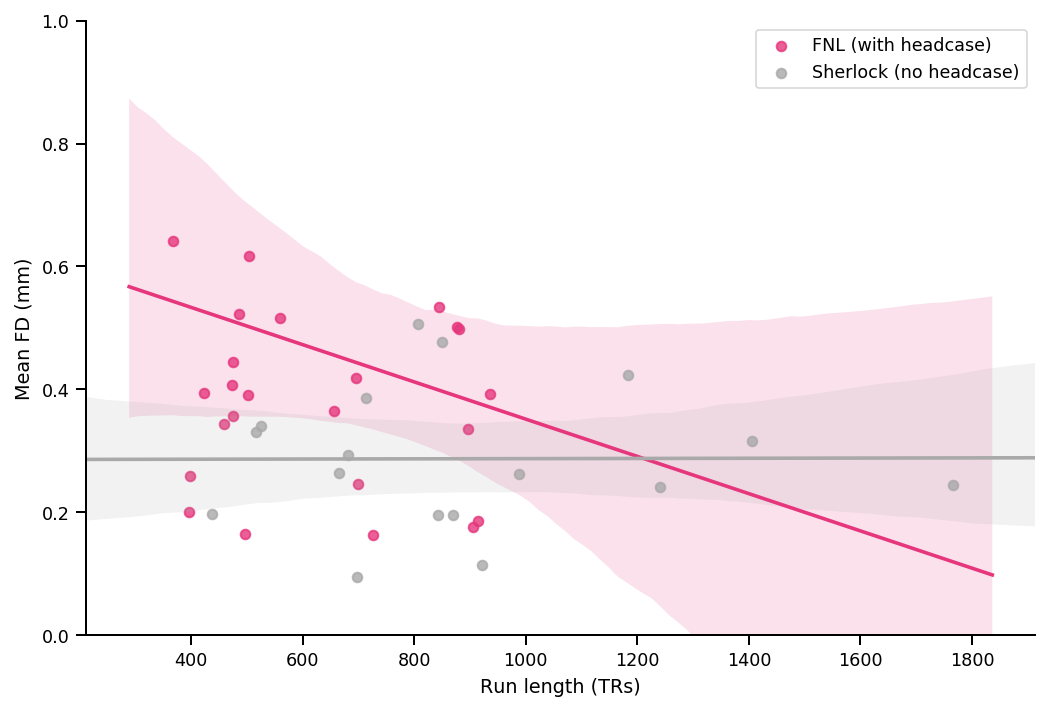

In [19]:
g = sns.lmplot(
    x="tr",
    y="FramewiseDisplacement",
    hue="dataset",
    data=all_data,
    legend=True,
    legend_out=False,
    palette=["#E6377D", "#A9A9A9"],
    height=5,
    aspect=1.5
)
g = g.set_axis_labels("Run length (TRs)", "Mean FD (mm)").set(ylim=(0, 1.0))
g.ax.legend(title='')
plt.savefig(fig_dir / "runlength_meanFD_recall.png", bbox_inches="tight", dpi=300)

## Rerun excluding high motion FNL subs

In [23]:
all_data_excluded = all_data.query("subject_id not in @high_motion_subs").reset_index(drop=True)
model = Lm("FramewiseDisplacement ~ center(tr) * C(dataset)", data=all_data_excluded)
model.fit(permute=5000, conf_int="boot", n_boot=5000)

Formula: FramewiseDisplacement~center(tr)*C(dataset)

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: boot (5000) 95%	Inference: permutation (5000) 

Number of observations: 41	 R^2: 0.121	 R^2_adj: 0.050

Log-likelihood: 26.152 	 AIC: -44.303	 BIC: -37.449

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,Num_perm,T-stat,Perm-P-val,Sig
Intercept,0.367,0.298,0.432,0.031,5000,11.650,0.109,
C(dataset)[T.Sherlock (no headcase)],-0.080,-0.168,0.013,0.048,5000,-1.673,0.106,
center(tr),-0.000,-0.000,0.000,0.000,5000,-0.739,0.470,
center(tr):C(dataset)[T.Sherlock (no headcase)],0.000,-0.000,0.000,0.000,5000,0.617,0.537,


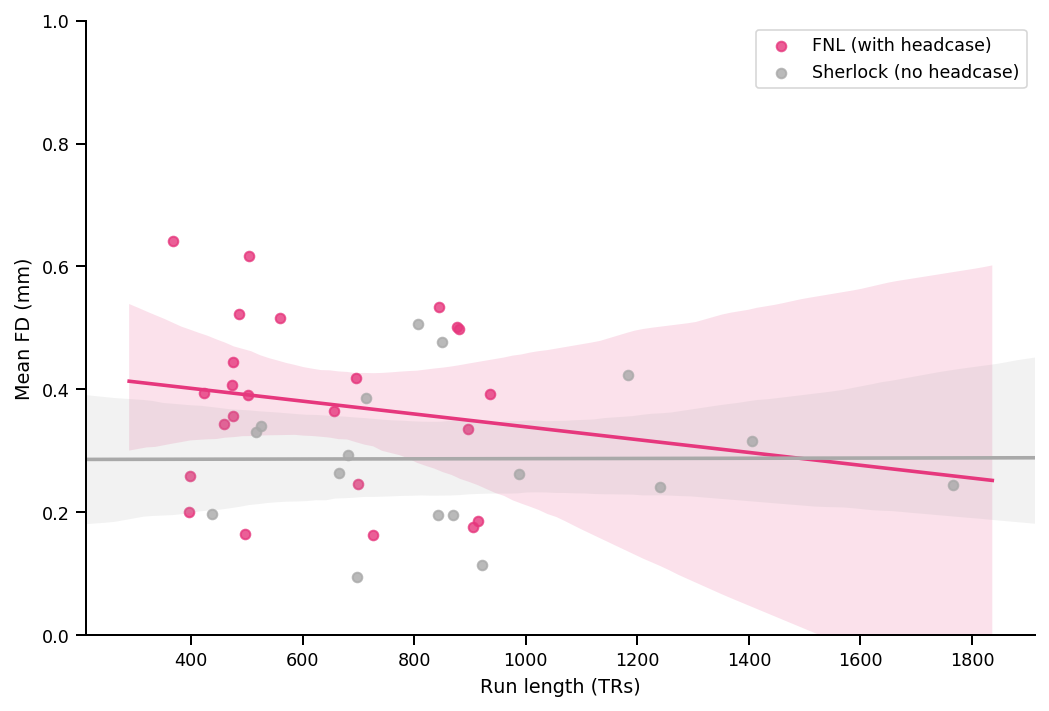

In [18]:
g = sns.lmplot(
    x="tr",
    y="FramewiseDisplacement",
    hue="dataset",
    data=all_data_excluded,
    legend=True,
    legend_out=False,
    palette=["#E6377D", "#A9A9A9"],
    height=5,
    aspect=1.5
)
g = g.set_axis_labels("Run length (TRs)", "Mean FD (mm)").set(ylim=(0, 1.0))
g.ax.legend(title='')
plt.savefig(fig_dir / "runlength_meanFD_recall_excluded.png", bbox_inches="tight", dpi=300)

# Linear drift of FD (*viewing*)  
No significant association between time and FD (linear drift).  
No difference between headcase (FNL) and non-headcase (FNL) participants.  
No interaction.  

In [74]:
def lin_reg(g):
    """Fit a linear regression to capture drift of FD over time"""
    model = LinearRegression()
    norm_order = np.linspace(-1, 1, all_fnl_ts.tr.max() + 1)
    poly = legendre(1)(norm_order)
    _ = model.fit(poly.reshape(-1, 1), g.FramewiseDisplacement.values.reshape(-1, 1))
    return model.coef_[0][0]


def log_reg(g):
    """Fit a logistic regression to capture whether probability of high motion TR (spike) increases over time drift of FD over time"""
    model = LogisticRegression(penalty='none')
    if g.spike.sum() > 0:
        _ = model.fit(g.tr.values.reshape(-1, 1), g.spike.values)
        return model.coef_[0][0]
    else:
        return np.nan

logit2prob = lambda x: np.exp(x) / (1 + np.exp(x))

In [75]:
# Load data
fnl_f17_ts_data = pd.read_csv(fnl_f17_ts)
fnl_f18_ts_data = pd.read_csv(fnl_f18_ts).query("condition == 'view'").reset_index(drop=True)
all_fnl_ts = pd.concat([fnl_f17_ts_data, fnl_f18_ts_data])

In [76]:
# legendre 1st order polynomial for linear drift
from scipy.special import legendre
norm_order = np.linspace(-1,1,all_fnl_ts.tr.max() + 1)
poly = legendre(1)(norm_order)

In [77]:
# Add spikes and legendre polynomial to dataframe
all_fnl_ts['spike'] = all_fnl_ts.FramewiseDisplacement > 0.3
all_fnl_ts['poly'] = np.tile(poly, all_fnl_ts.subject_id.nunique())

In [78]:
# Compute interaction between drift and headcase use
mg = Lmer('FramewiseDisplacement ~ poly * headcase + (poly|subject_id)',data=all_fnl_ts)
mg.fit()

Formula: FramewiseDisplacement~poly*headcase+(poly|subject_id)

Family: gaussian	 Inference: parametric

Number of observations: 85869	 Groups: {'subject_id': 63.0}

Log-likelihood: 11729.713 	 AIC: -23459.425

Random effects:

                   Name    Var    Std
subject_id  (Intercept)  0.005  0.073
subject_id         poly  0.001  0.038
Residual                 0.044  0.210

                    IV1   IV2  Corr
subject_id  (Intercept)  poly  0.34

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.129,0.100,0.157,0.014,61.014,8.907,0.000,***
poly,0.014,-0.001,0.030,0.008,61.000,1.850,0.069,.
headcaseno_case,-0.016,-0.053,0.021,0.019,61.014,-0.856,0.395,
poly:headcaseno_case,0.002,-0.018,0.022,0.010,61.000,0.190,0.850,


In [288]:
# Fit regression to each subject separately to get intercepts and slopes to draw lines below on the TR scale
m = Lm2('FramewiseDisplacement ~ tr',group='subject_id',data=all_fnl_ts)
m.fit(summarize=False)

Text(0.5, -0.01, 'TR')

Text(-0.01, 0.5, 'Framewise Displacment (mm)')

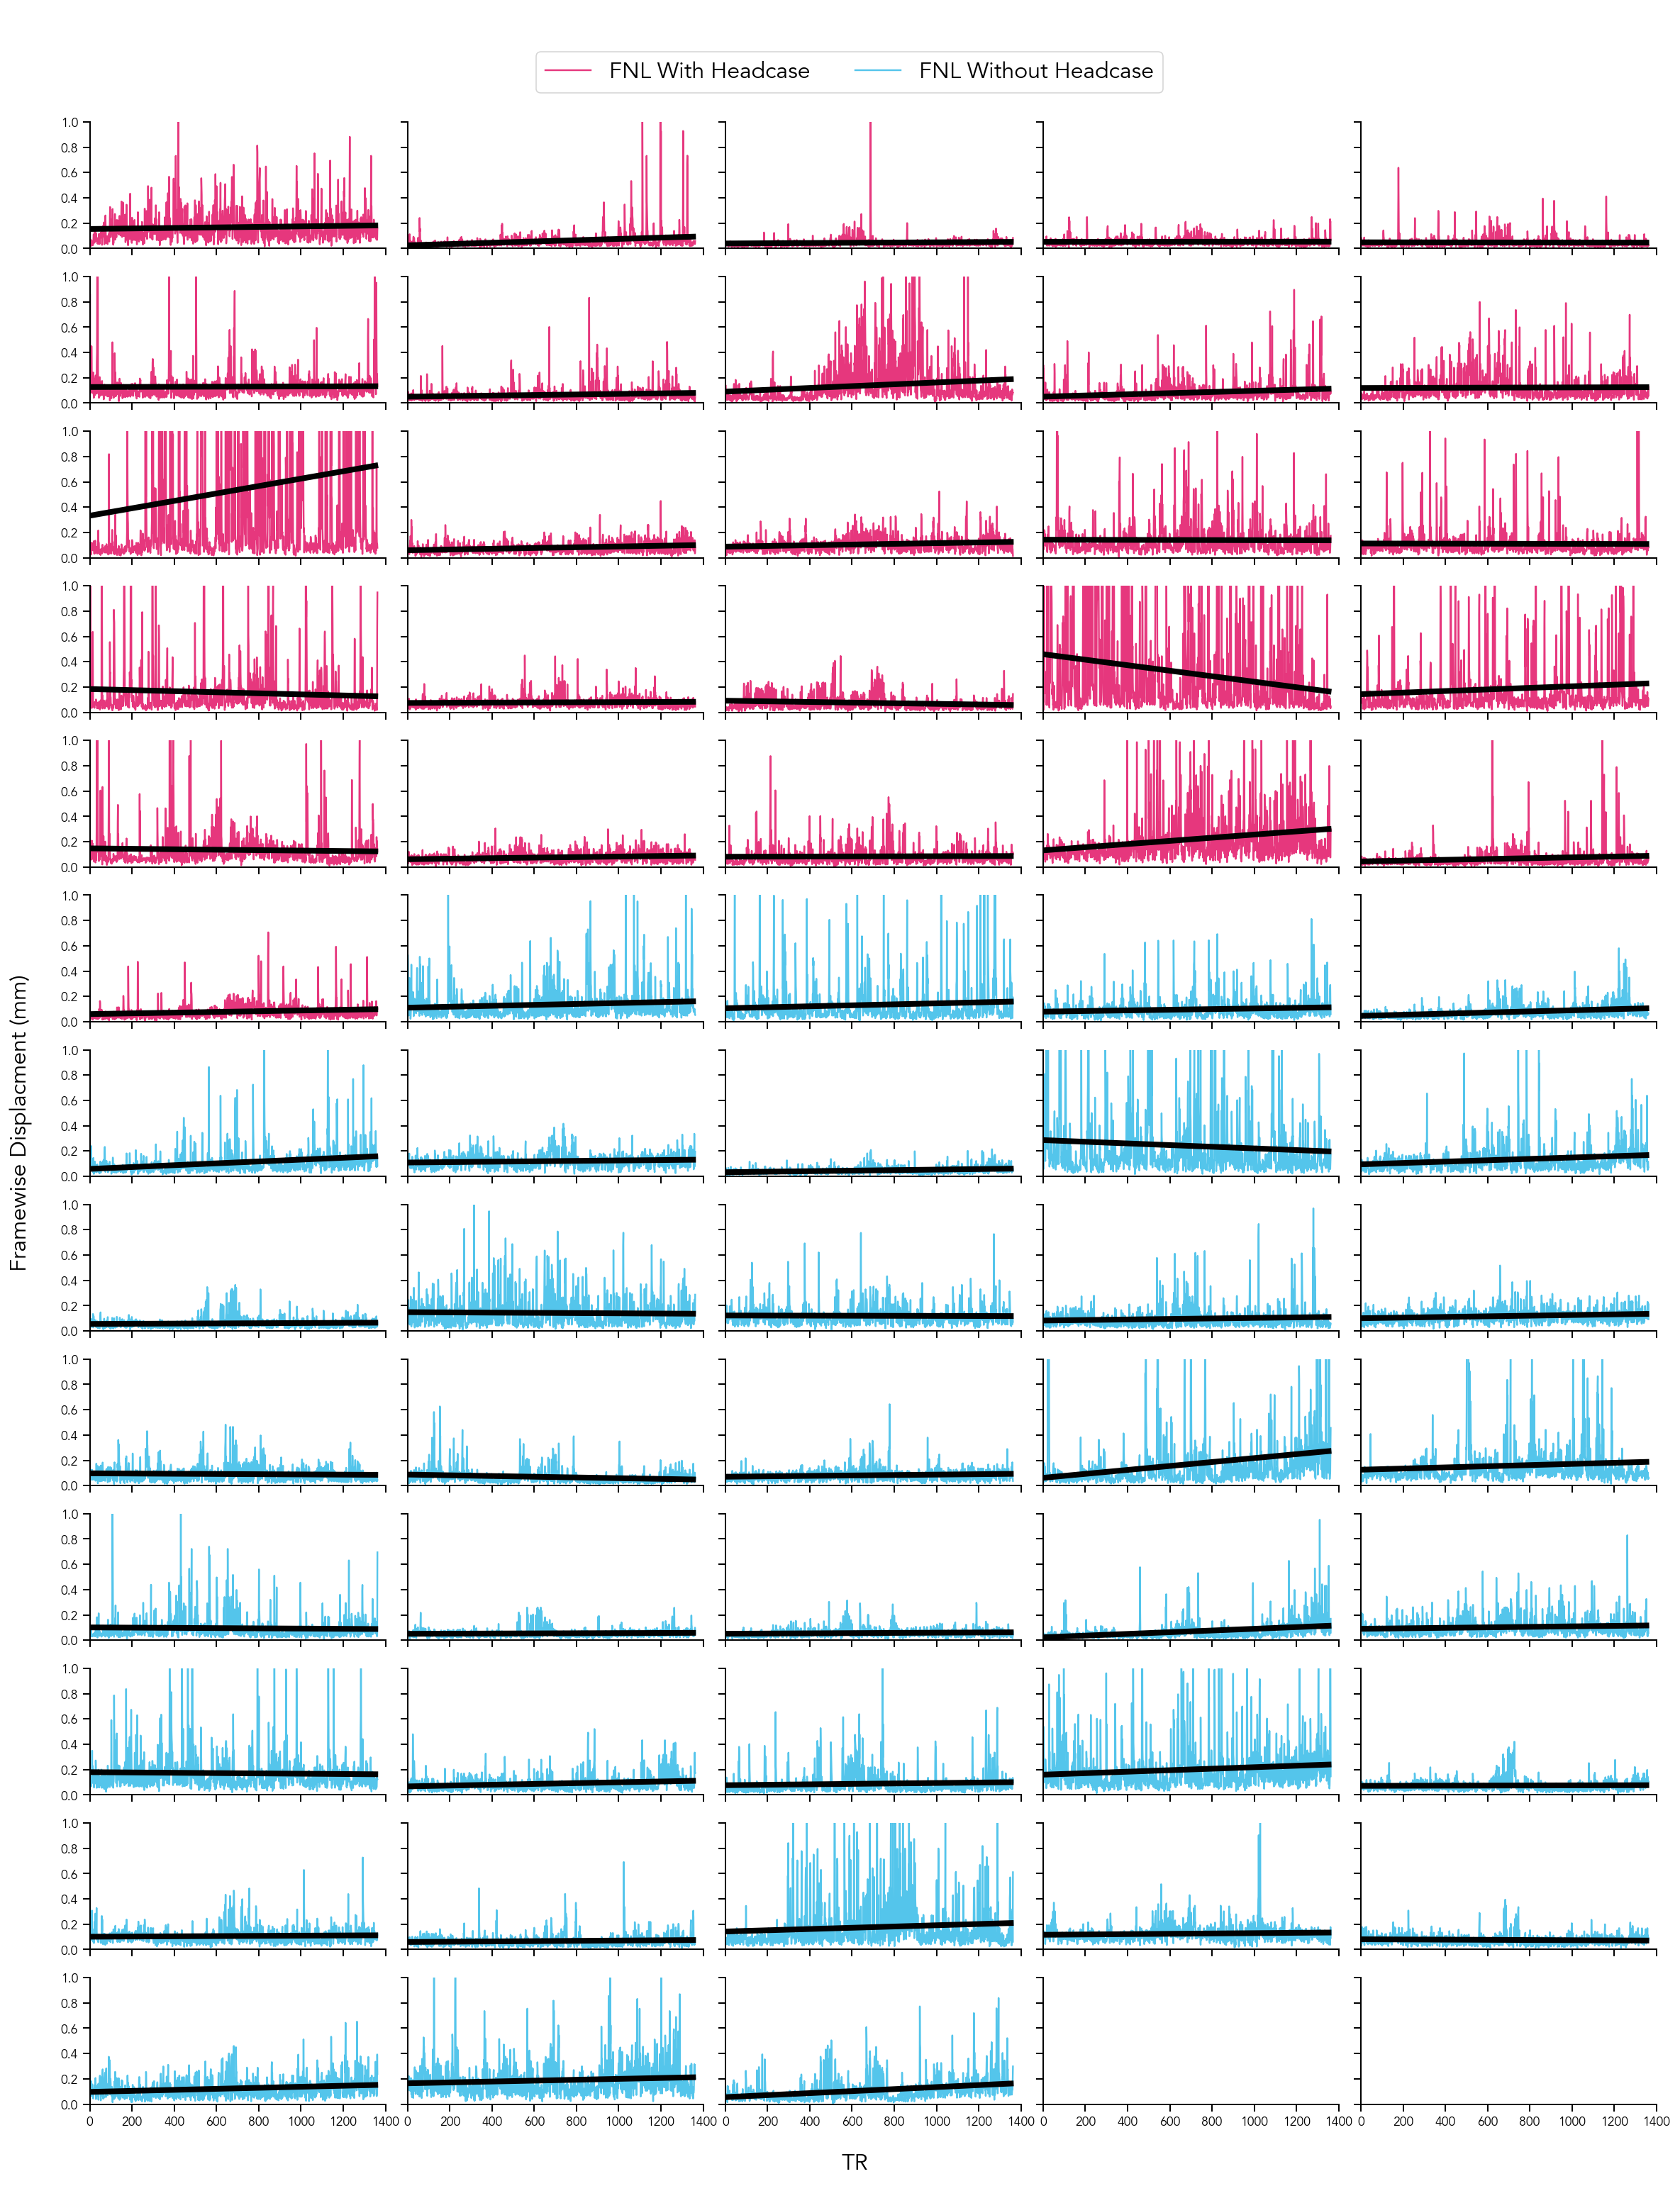

In [84]:
f, axs = plt.subplots(13, 5, figsize=(16, 20), sharex=True, sharey=True)
subs = all_fnl_ts.subject_id.unique()
idx = np.argsort(
    [all_fnl_ts.query("subject_id == @s").headcase.unique()[0] for s in subs]
)
subs = subs[idx]
legend_lines = []
for i, (sub, ax) in enumerate(zip(subs, axs.flat)):
    df = all_fnl_ts.query("subject_id == @sub")
    if df.headcase.unique()[0] == "no_case":
        color = "#54c5eb"
    else:
        color = "#E6377D"
    ys = m.fixef.loc[sub].Intercept + (np.arange(0, 1353) * m.fixef.loc[sub].tr)
    _ = ax.plot("tr", "FramewiseDisplacement", data=df, color=color)
    if i == 0 or i == len(subs) - 1:
        legend_lines.append(ax.get_legend_handles_labels()[0][0])
    _ = ax.plot(np.arange(1353), ys, color="black", lw=4, ls="-")
    _ = ax.set(ylim=(0, 1), xlim=(0, 1400))
    sns.despine()
f.legend(
    legend_lines,
    ["FNL With Headcase", "FNL Without Headcase"],
    loc="center",
    ncol=2,
    fontsize=16,
    bbox_to_anchor=(0.52, 1.035),
);
f.text(0.5, -0.01, "TR", ha="center", va="center", fontsize=16);
f.text(
    -0.01,
    0.5,
    "Framewise Displacment (mm)",
    ha="center",
    va="center",
    rotation="vertical",
    fontsize=16,
);
plt.tight_layout();
plt.savefig(fig_dir / "FD_lineardrift.png", bbox_inches="tight", dpi=300)

# Linear drift of Spikes (*viewing*)  
Significant increase in spike probability over time.  
No difference between headcase (FNL) and non-headcase (FNL) participants.  
No interaction.  

In [10]:
# Compute interaction between drift and spikes
spike_m = Lmer('spike ~ poly * headcase + (poly|subject_id)',data=all_fnl_ts, family='binomial')
spike_m.fit()

Formula: spike~poly*headcase+(poly|subject_id)

Family: binomial	 Inference: parametric

Number of observations: 85869	 Groups: {'subject_id': 63.0}

Log-likelihood: -14699.424 	 AIC: 29412.847

Random effects:

                   Name    Var    Std
subject_id  (Intercept)  2.365  1.538
subject_id         poly  0.326  0.571

                    IV1   IV2   Corr
subject_id  (Intercept)  poly -0.177

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-3.747,-4.350,-3.144,0.308,0.024,0.013,0.043,0.023,0.013,0.041,-12.179,0.000,***
poly,0.442,0.166,0.718,0.141,1.556,1.181,2.050,0.609,0.541,0.672,3.143,0.002,**
headcaseno_case,-0.056,-0.841,0.729,0.400,0.945,0.431,2.072,0.486,0.301,0.675,-0.140,0.889,
poly:headcaseno_case,0.060,-0.282,0.402,0.174,1.062,0.755,1.494,0.515,0.430,0.599,0.344,0.731,


Text(0.5, -0.01, 'TR')

Text(-0.01, 0.5, 'Spike Probability')

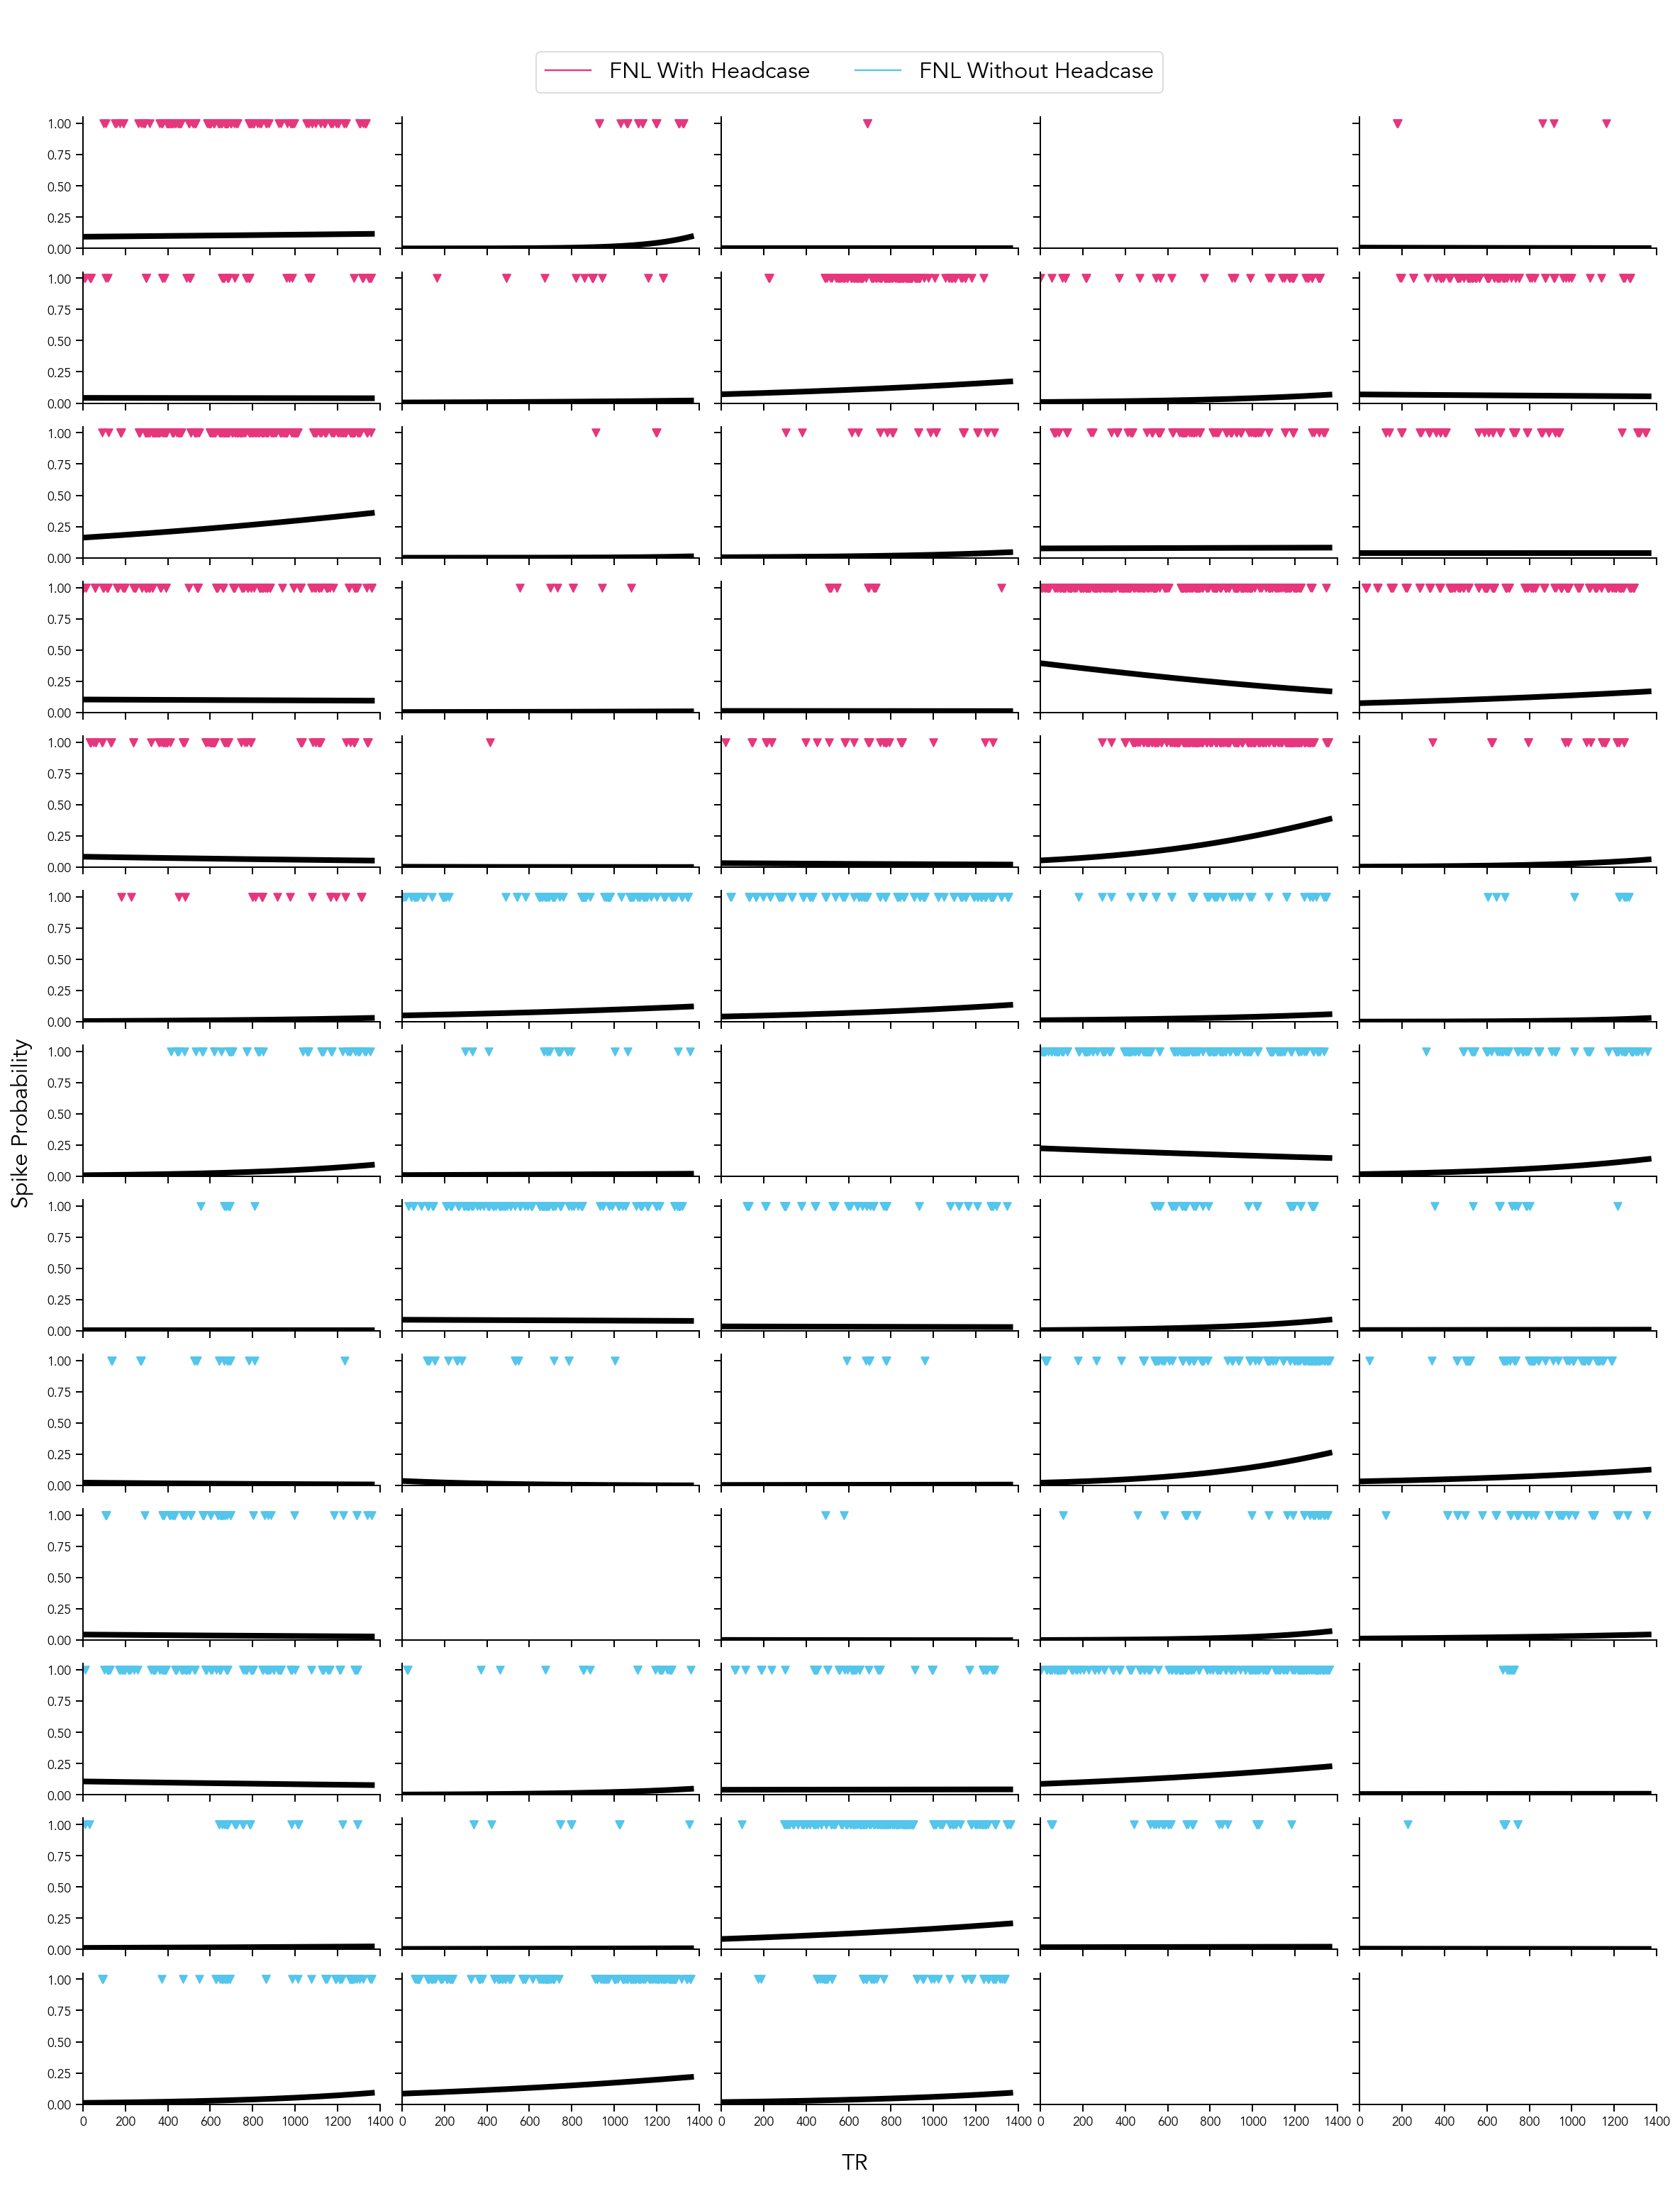

In [90]:
f, axs = plt.subplots(13, 5, figsize=(16, 20), sharex=True, sharey=True)
subs = all_fnl_ts.subject_id.unique()
idx = np.argsort(
    [all_fnl_ts.query("subject_id == @s").headcase.unique()[0] for s in subs]
)
subs = subs[idx]
# legend_lines = []
for i, (sub, ax) in enumerate(zip(subs, axs.flat)):
    df = all_fnl_ts.query("subject_id == @sub")
    if df.spike.sum() > 0:
        if df.headcase.unique()[0] == "no_case":
            color = "#54c5eb"
        else:
            color = "#E6377D"
        # Fit logistic regression to this subject and get predictions
        log = LogisticRegression(penalty='none')
        _ = log.fit(df.tr.values.reshape(-1,1),df.spike.values)
        ys = log.predict_proba(df.tr.values.reshape(-1,1))
        
        _ = ax.plot(df.tr.values, ys[:,1], color='black', lw=4)
        _ = ax.scatter(df.tr.values, df.spike.map({False:np.nan,True:1}).values,marker='v',s=30, color=color)

    _ = ax.set(ylim=(0, 1.05), xlim=(0, 1400))
    sns.despine()
# Reusing the same ones from the previous plot
f.legend(
    legend_lines,
    ["FNL With Headcase", "FNL Without Headcase"],
    loc="center",
    ncol=2,
    fontsize=16,
    bbox_to_anchor=(0.52, 1.035),
);
f.text(0.5, -0.01, "TR", ha="center", va="center", fontsize=16);
f.text(
    -0.01,
    0.5,
    "Spike Probability",
    ha="center",
    va="center",
    rotation="vertical",
    fontsize=16,
);
plt.tight_layout();
plt.savefig(fig_dir / "Spike_lineardrift.png", bbox_inches="tight", dpi=300)

# Stimulus Correlated Motion Analyses  
Significantly more ISC of FD in without headcases (FNL) compared to with headcases (FNL).  
Not true of non-differences (raw) motion params.  
SRM components do show group differences.  

## ISC of Framewise Displacement

In [8]:
from itertools import combinations
from scipy.stats import t as tdist
from nltools.stats import align
from scipy.stats import zscore
from lib.n00 import calc_motion_deltas, get_mat_file
from scipy.spatial.distance import pdist
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import KFold
from lib.utils import annotate_axis

In [30]:
def correct_isc_pvals(model_list, estimate_idx=1, method="fdr_bh"):
    """Corrects p-values from a list of LMMs used to estimated ISC analyses"""
    dfs, ps = [], []
    for m in model_list:
        df = np.round(m.coefs.iloc[estimate_idx, 4] / 2, 3)
        p = np.round(2 * (1 - tdist.cdf(np.abs(m.coefs.iloc[estimate_idx, 5]), df)), 4)
        dfs.append(df)
        ps.append(p)

    ps = multipletests(ps, method=method)[1]
    return dfs, ps

In [9]:
fnl_f17_ts_data = pd.read_csv(fnl_f17_ts)
fnl_f18_ts_data = pd.read_csv(fnl_f18_ts).query("condition =='view'").reset_index(drop=True)
fnl_f17_ts_data = pd.concat([fnl_f17_ts_data, fnl_f18_ts_data.query("headcase == 'no_case'")],axis=0)
fnl_f18_ts_data = fnl_f18_ts_data.query("headcase == 'has_case'").reset_index(drop=True)

fnl_f17_corr = fnl_f17_ts_data.pivot(index='tr',columns='subject_id',values='FramewiseDisplacement').corr()
fnl_f17_corr = Adjacency(fnl_f17_corr.values, labels=list(fnl_f17_corr.index))

fnl_f18_corr = fnl_f18_ts_data.pivot(index='tr',columns='subject_id',values='FramewiseDisplacement').corr()
fnl_f18_corr = Adjacency(fnl_f18_corr.values, labels=list(fnl_f18_corr.index))

corr_comparison_df = pd.DataFrame(
    {
        "headcase": ["no_case"] * len(fnl_f17_corr.data)
        + ["has_case"] * len(fnl_f18_corr.data),
        "correlation": np.hstack([fnl_f17_corr.data, fnl_f18_corr.data]),
        "s1": np.hstack(
            [
                np.array(list(combinations(fnl_f17_corr.labels, 2)))[:, 0],
                np.array(list(combinations(fnl_f18_corr.labels, 2)))[:, 0],
            ]
        ),
        "s2": np.hstack(
            [
                np.array(list(combinations(fnl_f17_corr.labels, 2)))[:, 1],
                np.array(list(combinations(fnl_f18_corr.labels, 2)))[:, 1],
            ]
        ),
    }
)

In [10]:
isc_m = Lmer('correlation ~ headcase + (1|s1) + (1|s2)',data=corr_comparison_df)
isc_m.fit()

Formula: correlation~headcase+(1|s1)+(1|s2)

Family: gaussian	 Inference: parametric

Number of observations: 991	 Groups: {'s1': 61.0, 's2': 61.0}

Log-likelihood: 1681.820 	 AIC: -3363.640

Random effects:

                 Name    Var    Std
s1        (Intercept)  0.000  0.019
s2        (Intercept)  0.000  0.016
Residual               0.002  0.041

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.021,0.010,0.032,0.006,95.305,3.592,0.001,***
headcaseno_case,0.017,0.002,0.032,0.007,92.209,2.253,0.027,*


In [14]:
# Adjust dof for double elements
new_dof = isc_m.coefs.iloc[1,4] / 2
new_p = 2 * (1 - tdist.cdf(np.abs(isc_m.coefs.iloc[1,5]),new_dof))
print(f"Adjusted DOF: {new_dof}; Adjusted p-val: {new_p} ")

Adjusted DOF: 46.10464632774477; Adjusted p-val: 0.029038673128754855 


In [151]:
corr_comparison_df.groupby('headcase').correlation.agg(['mean','std'])

,mean,std
headcase,,
has_case,0.019341,0.042273
no_case,0.038115,0.050302


## ISC of raw (non-differenced) motion parameters

In [112]:
fnl17_expanded = []
for sub in fnl_f17_subs:
    fnl17_expanded.append(
        calc_motion_deltas(get_mat_file(sub), diff=False, normalize=True)[0]
    )
    
fnl18_expanded = []
for sub in fnl_f18_subs:
    if sub.name in fnl_f18_no_case:
        fnl17_expanded.append(
            calc_motion_deltas(get_mat_file(sub), diff=False, normalize=True)[0]
        )
    else:
        fnl18_expanded.append(
            calc_motion_deltas(get_mat_file(sub), diff=False, normalize=True)[0]
        )
assert len(fnl17_expanded) == 37
assert len(fnl18_expanded) == 26



# Compute ISC between motion 
x = np.array(fnl17_expanded)
mpars_isc = []
for i in range(6):
    mpars_isc.append(1 - pdist(x[:, :, i], metric="correlation"))
mpars_isc_f17 = pd.DataFrame(
    np.column_stack(mpars_isc), columns=["x", "y", "z", "pitch", "roll", "yaw"]
)
mpars_isc_f17["headcase"] = "no_case"

x = np.array(fnl18_expanded)
mpars_isc = []
for i in range(6):
    mpars_isc.append(1 - pdist(x[:, :, i], metric="correlation"))
mpars_isc_f18 = pd.DataFrame(
    np.column_stack(mpars_isc), columns=["x", "y", "z", "pitch", "roll", "yaw"]
)
mpars_isc_f18["headcase"] = "has_case"

mpars_isc = pd.concat([mpars_isc_f17, mpars_isc_f18], axis=0).melt(
    id_vars="headcase", var_name="direction", value_name="isc"
)

f17subs = [s.name for s in fnl_f17_subs]
f18subs = [s.name for s in fnl_f18_with_case]
f17subs += fnl_f18_no_case

mpars_isc_f17['s1'] = np.array(list(combinations(f17subs, 2)))[:, 0]
mpars_isc_f17['s2'] = np.array(list(combinations(f17subs, 2)))[:, 1]
mpars_isc_f18['s1'] = np.array(list(combinations(f18subs, 2)))[:, 0]
mpars_isc_f18['s2'] = np.array(list(combinations(f18subs, 2)))[:, 1]

mpars_isc = pd.concat([mpars_isc_f17, mpars_isc_f18], axis=0).melt(
    id_vars=["headcase","s1","s2"], var_name="direction", value_name="isc"
)

In [ ]:
mmodels = []
for c in mpars_isc.direction.unique():
    df = mpars_isc.query("direction == @c").reset_index(drop=True)
    m = Lmer('isc ~ headcase + (1|s1) + (1|s2)',data=df,)
    m.fit(summarize=False)
    mmodels.append(m)    

In [31]:
dfs, ps = correct_isc_pvals(mmodels)
for d, df, p in zip(mpars_isc.direction.unique(), dfs, ps):
    print(f"Direction: {d} DF: {df} p: {p}")

Direction: x DF: 29.489 p: 0.7989599999999999
Direction: y DF: 494.5 p: 0.7989599999999999
Direction: z DF: 51.151 p: 0.7989599999999999
Direction: pitch DF: 49.981 p: 0.9953
Direction: roll DF: 494.5 p: 0.7989599999999999
Direction: yaw DF: 21.432 p: 0.4338


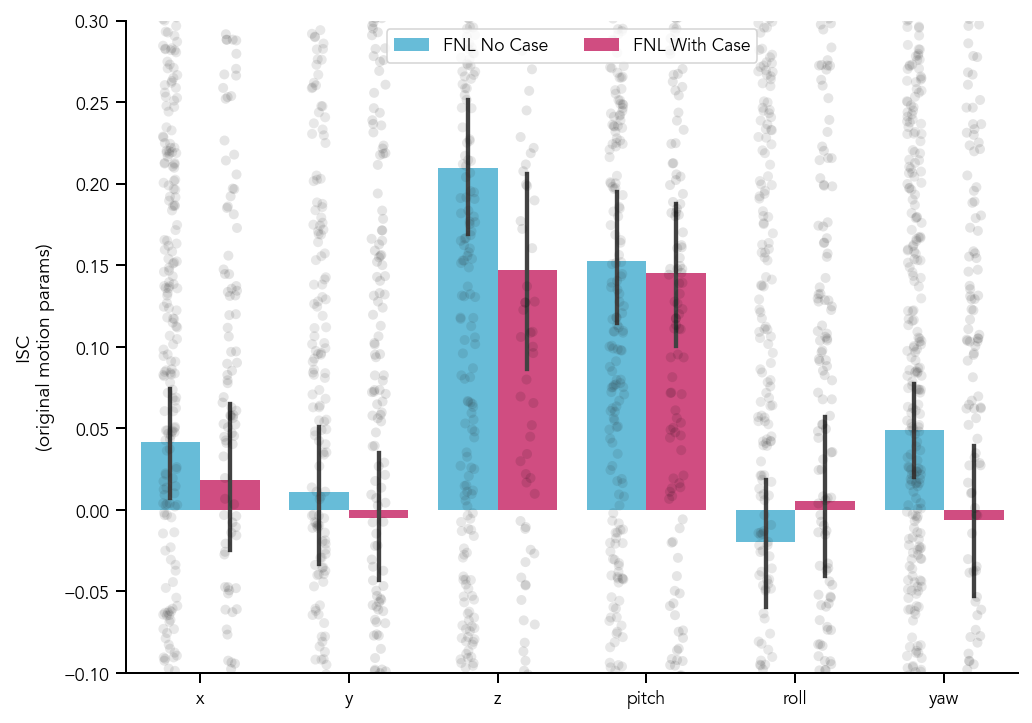

In [116]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.barplot(x='direction',y='isc',hue='headcase',data=mpars_isc,palette= ["#54c5eb", "#E6377D"],ax=ax
)
ax = sns.stripplot(x='direction',y='isc',hue='headcase',data=mpars_isc,color='black', dodge=True, ax=ax, alpha=0.1
)
_ = ax.set(xlabel='', ylabel='ISC\n(original motion params)', ylim=(-.1, .3))
handles, labels = ax.get_legend_handles_labels();
handles = handles[2:]
labels = ['FNL No Case', 'FNL With Case']
ax.legend(handles, labels, loc='upper center', ncol= 2)
sns.despine();
plt.savefig(fig_dir / 'mpars_isc.png', bbox_inches="tight", dpi=300)

## ISC of SRM-aligned motion parameters

In [65]:
srm_all = align(fnl17_expanded + fnl18_expanded, axis=1)
all_isc = srm_all["isc"]
srm_all_df = []
f17_transformed = np.array(srm_all["transformed"][:37])
f18_transformed = np.array(srm_all["transformed"][37:])
comp_names = [f"{i}" for i in range(1, 7)]

mpars_isc = []
for i in range(6):
    mpars_isc.append(1 - pdist(f17_transformed[:, :, i], metric="correlation"))
transformed_isc_f17 = pd.DataFrame(np.column_stack(mpars_isc), columns=comp_names)
transformed_isc_f17["headcase"] = "no_case"

mpars_isc = []
for i in range(6):
    mpars_isc.append(1 - pdist(f18_transformed[:, :, i], metric="correlation"))
transformed_isc_f18 = pd.DataFrame(np.column_stack(mpars_isc), columns=comp_names)
transformed_isc_f18["headcase"] = "has_case"

transformed_isc = pd.concat([transformed_isc_f17, transformed_isc_f18], axis=0).melt(
    id_vars="headcase", var_name="component", value_name="isc"
)

In [67]:
f17subs = [s.name for s in fnl_f17_subs]
f18subs = [s.name for s in fnl_f18_with_case]
f17subs += fnl_f18_no_case

transformed_isc_f17['s1'] = np.array(list(combinations(f17subs, 2)))[:, 0]
transformed_isc_f17['s2'] = np.array(list(combinations(f17subs, 2)))[:, 1]
transformed_isc_f18['s1'] = np.array(list(combinations(f18subs, 2)))[:, 0]
transformed_isc_f18['s2'] = np.array(list(combinations(f18subs, 2)))[:, 1]

transformed_isc = pd.concat([transformed_isc_f17, transformed_isc_f18], axis=0).melt(
    id_vars=["headcase","s1","s2"], var_name="component", value_name="isc"
)

In [68]:
models = []
for c in transformed_isc.component.unique():
    df = transformed_isc.query("component == @c").reset_index(drop=True)
    m = Lmer('isc ~ headcase + (1|s1) + (1|s2)',data=df)
    m.fit(summarize=False)
    models.append(m)    

In [70]:
dfs, ps = correct_isc_pvals(models)
for d, df, p in zip(transformed_isc.component.unique(), dfs, ps):
    print(f"Direction: {d} DF: {df} p: {p}")

Direction: 1 DF: 57.277 p: 0.003
Direction: 2 DF: 57.158 p: 0.00948
Direction: 3 DF: 54.744 p: 0.0088
Direction: 4 DF: 55.903 p: 0.0057
Direction: 5 DF: 55.632 p: 0.00948
Direction: 6 DF: 52.1 p: 0.0711


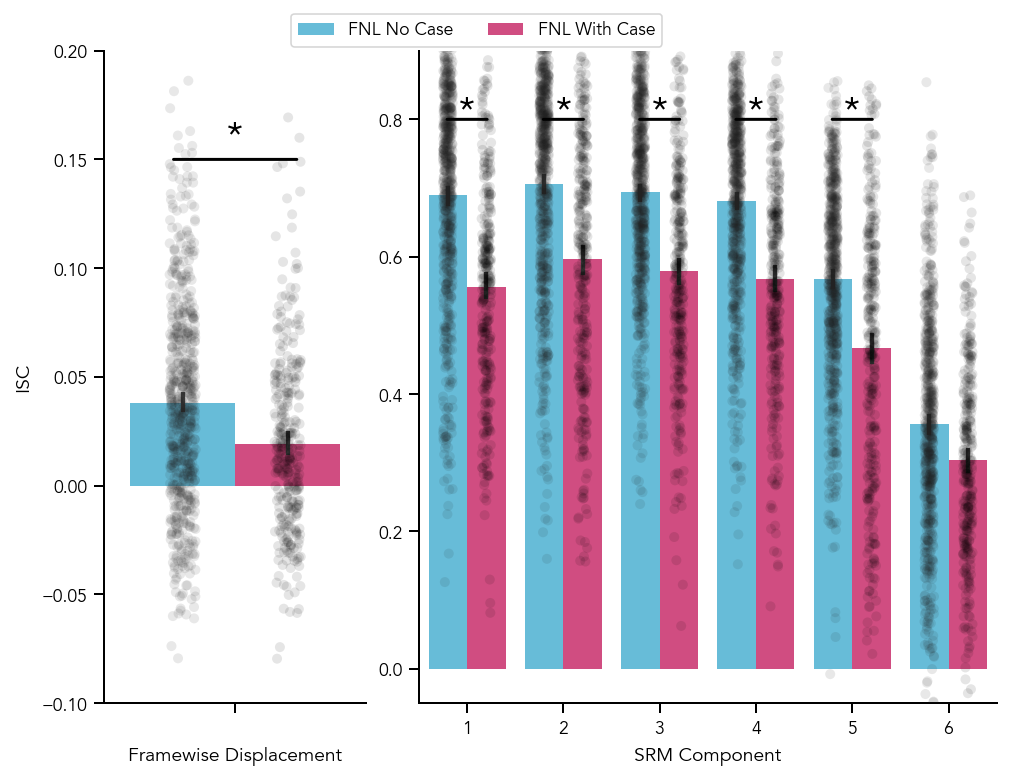

In [110]:
corr_comparison_df['isc_label'] = 'Framewise Displacement'
f = plt.figure(figsize=(8,6))

g = f.add_gridspec(2,3)
ax1 = f.add_subplot(g[:, 0])
palette = ["#54c5eb", "#E6377D"]

ax1 = sns.barplot(
    x="isc_label", y="correlation", hue="headcase", data=corr_comparison_df, ax=ax1, palette=palette,
)
ax1 = sns.stripplot(
    x="isc_label",
    y="correlation",
    hue= "headcase",
    data=corr_comparison_df,
    ax=ax1,
    dodge=True,
    color="black",
    alpha=0.1,
)
_ = ax1.set(
    ylim=(-.10, 0.2),
    xlabel="Framewise Displacement",
    xticklabels=[" "],
    ylabel="ISC",
)
_ = ax1.legend().remove();
sns.despine()
ax1 = annotate_axis(ax1, [-.25], [.25], [0.15], ["*"])

ax2 = f.add_subplot(g[:, 1:])
ax2 = sns.barplot(
    x="component",
    y="isc",
    hue="headcase",
    data=transformed_isc,
    palette=["#54c5eb", "#E6377D"],
    ax=ax2,
)
ax2 = sns.stripplot(
    x="component",
    y="isc",
    hue="headcase",
    data=transformed_isc,
    color="black",
    dodge=True,
    ax=ax2,
    alpha=0.1,
)
_ = ax2.set(xlabel="SRM Component", ylabel="", ylim=(-0.05, 0.9),title='')
handles, labels = ax2.get_legend_handles_labels()
handles = handles[2:]
labels = ["FNL No Case", "FNL With Case"]
ax2.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.1, 1.07))
sns.despine()
ax2 = annotate_axis(ax2, [-.25, 0.75, 1.75, 2.75, 3.75], [0.25, 1.25, 2.25, 3.25, 4.25], [0.8]*5, ["*"]*5)
plt.savefig(fig_dir / 'joint_SRM_isc.png', bbox_inches="tight", dpi=300)

# Power Spectra
Following [Fair et al, 2020](https://www.sciencedirect.com/science/article/pii/S1053811919309917#appsec2)

In [ ]:
from numpy.fft import fft, ifft, fftfreq
from lib.n00 import calc_motion_deltas, get_mat_file
from scipy.stats import zscore
from mne.time_frequency import psd_array_multitaper

fd_summary = pd.read_csv(analysis_dir / "fd_summary.csv")

# decibal normalization
db = lambda arr: 10 * np.log10(arr)

In [5]:
def multi_zscore(mats):
    """Handle zscore for 3d numpy array or list of differently shaped 2d numpy arrays"""
    if isinstance(mats, list) or mats.ndim == 1:
        out = [zscore(mat, axis=0) for mat in mats]
    else:
        out = zscore(mats, axis=1)
    return out


def multi_minmax(mats):
    """Handle minmax normalization for 3d numpy array or list of different shaped 2d numpy arrays"""
    if isinstance(mats, list) or mats.ndim == 1:
        mins = [mat.min() for mat in mats]
        maxs = [mat.max() for mat in mats]
        mmin = np.min(mins)
        mmax = np.max(maxs)
        out = [((mat - mmin) / (mmax - mmin)) * 100 for mat in mats]
    else:
        out = ((mats - mats.min()) / (mats.max() - mats.min())) * 100
    return out


def pad_jagged_arraylist(mats):
    """Take a list of 2d arrays that vary along their first dimension and match their length (to the largest array) by padding with 0s. Returns a 3d array"""
    shapes = [e.shape[0] for e in mats]
    mmax = np.max(shapes)
    out = [np.pad(e, [(0, mmax - e.shape[0]), (0, 0)], mode="constant") for e in mats]
    return np.array(out)

In [63]:
def compute_spectra(subs, mats, fd_summary, TR = 2.0, normalization='full', low_bias=False, verbose=False, **kwargs):
    """
    Compute multi-taper spectral decomposition. Extra arguments go to mne's psd_array_multitaper
    
    Args:
        subs: list of subject paths
        mats: list of [time x direction] mpars of length len(subs)
        fd_summary: DataFrame of mean FD summary file
        kwargs: additional arguments to mne.time_frequency.psd_array_multitaper
    Returns:
        array of mean FDs for each sub sorted from lowest to highest
        3d array of power spectra mats [sub x freq x direction] also sorted by mean FD along the first axis
        array of frequencies in which power was computed
    """
    
    fds, psds, freqs = [], [], []
    
    for i, (sub, mat) in enumerate(zip(subs, mats)):
        # Multi-taper decomposition
        psd, freq = psd_array_multitaper(mat.T, 1/TR,  normalization=normalization, low_bias=low_bias, verbose=verbose, **kwargs)       
        
        # Convert to dB
        psd = db(psd).T
    
        # Get mean FD for sorting later
        subject_id = sub.name
        fd = fd_summary.query(
            "subject_id == @subject_id and measure == 'fd_mean'"
        ).val.values[0]
        
        fds.append(fd)
        psds.append(psd)
        freqs.append(freq)

    fds = np.array(fds)
    psds = np.array(psds)
    freqs = np.array(freqs)

    # Sort by FD
    idx = np.argsort(fds)
    fds = np.sort(fds)
    psds = psds[idx]
    freqs = freqs[idx]
    
    return fds, psds, freqs

In [155]:
def match_spectra_length(freqs, psds, interpolation="cubic"):
    """
    For plotting purposes shrink all psds down to the participant with the shortest length.
    interpolation options are based on scipy interp1d
    """

    from scipy.interpolate import interp1d

    min_idx = np.argmin([e.shape[0] for e in psds])
    min_freqs = freqs[min_idx]
    # Ensure the highest frequency is the same as the max possible frequency
    # due to rounding errors which will result in an error because of trying to 
    # interpolate beyond the range of the data
    max_idx = np.argmax([e.shape[0] for e in psds])
    min_freqs[-1] = freqs[max_idx][-1]
       
    new_psds = []
    for i, (freq, psd) in enumerate(zip(freqs, psds)):
        # Learn mapping between freqs and psds
        func = interp1d(freq, psd, axis=0, kind=interpolation, bounds_error=False, fill_value='extrapolate')
        # Generate a new psd based on the matrix with the shortest length
        new_psd = func(min_freqs)
        new_psds.append(new_psd)
    return new_psds, min_freqs

In [205]:
def plot_spectra(mat, freqs, fds, normalization="minmax", cmap="jet", title=''):
    """
    Make a power spectra plot like Fair et al, 2020. 
    Possible normalizations are:
        - 'minmax': 0-100 using the min and max of *all data* (highlights subject differences)
        - 'zscore': zscore within subject across frequencies
        - 'zscore_minmax': zscore then compute minmax
        - 'raw': plot raw dBs
        
    """

    # Setup plot params
    sns.set_context("paper")
    fig, axs = plt.subplots(2, 3, figsize=(14, 10), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.91, 0.3, 0.02, 0.4])
    directions = ["x", "y", "z", "pitch", "roll", "yaw"]
    max_shape = np.max([e.shape[0] for e in mat])
    xticks = np.linspace(0, max_shape, 3)
    if freqs.ndim == 2:
        f = freqs[0]
    else:
        f = freqs
    xticklabels = np.round([f[0], np.take(f, f.size // 2), f[-1]], 2)
    max_fds = len(fds)
    yticks = np.linspace(0, max_fds, 5)
    yticklabels = np.hstack([np.round(fds, 2)[::5], np.round(fds, 2)[-1]])
    ylabel = "Mean FD (mm)\nhigh movers                             low movers"
    xlabel = "Freq (Hz)"
    cmap = cmap

    # Handle normalization
    if normalization == "minmax":
        plot_mat = multi_minmax(mat)
        cbar_label = "Relative Percent Power (dB)"
    elif normalization == "zscore":
        plot_mat = multi_zscore(mat)
        cbar_label = "Power (z-score)"
    elif normalization == "zscore_minmax":
        plot_mat = multi_minmax(multi_zscore(mat))
        cbar_label = "Relative percent Power (z-score)"
    elif normalization == "raw":
        plot_mat = mat
        cbar_label = "Power (dB)"
    else:
        raise ValueError("invalid normalization value; see function help")
        
    # Handle jagged array, i.e. for talking psds
    if isinstance(plot_mat, list) or plot_mat.ndim == 1:
        plot_mat = pad_jagged_arraylist(plot_mat)

    vmin, vmax = np.nanmin(plot_mat), np.nanmax(plot_mat)

    for i, d in enumerate(directions):
        ax = sns.heatmap(
            plot_mat[:, :, i],
            square=False,
            ax=axs.flat[i],
            cmap=cmap,
            cbar=i == 0,
            vmin=vmin,
            vmax=vmax,
            cbar_ax=None if i else cbar_ax,
        )
        _ = ax.set_xticks(xticks)
        _ = ax.set_xticklabels(xticklabels, rotation=0, fontsize=14)
        _ = ax.set_yticks(yticks)
        _ = ax.set_yticklabels(yticklabels, rotation=0, fontsize=14)
        _ = ax.set_title(d, fontsize=14)
        if i > 2:
            _ = ax.set_xlabel(xlabel, fontsize=16)
        if i == 0 or i == 3:
            _ = ax.set_ylabel(ylabel, fontsize=16)
    _ = cbar_ax.set_ylabel(cbar_label, rotation=270, fontsize=16, labelpad=12)
    plt.setp(cbar_ax.get_yticklabels(), fontsize=14)

    _ = fig.suptitle(title, y=1.02, fontsize=18)
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    return fig, axs

In [8]:
# Create lists of all subs containing unmodified mpars
fnl17_expanded = []
for sub in fnl_f17_subs:
    fnl17_expanded.append(
        calc_motion_deltas(get_mat_file(sub), diff=False, normalize=False)[0]
    )

fnl18_expanded = []
for sub in fnl_f18_subs:
    if sub.name in fnl_f18_no_case:
        fnl17_expanded.append(
            calc_motion_deltas(get_mat_file(sub), diff=False, normalize=False)[0]
        )
    else:
        fnl18_expanded.append(
            calc_motion_deltas(get_mat_file(sub), diff=False, normalize=False)[0]
        )

# Sherlock talking only
sherlock_expanded = []
for sub in sherlock_subs:
    sherlock_expanded.append(
        calc_motion_deltas(
            get_mat_file(sub, condition="recall"), diff=False, normalize=False
        )[0]
    )

fnl18_expanded_talk = []
for sub in fnl_f18_with_case:
    fnl18_expanded_talk.append(
        calc_motion_deltas(
            get_mat_file(sub, condition="recall"), diff=False, normalize=False
        )[0]
    )
assert len(fnl17_expanded) == 37
assert len(fnl18_expanded) == 26
assert len(sherlock_expanded) == 17
assert len(fnl18_expanded_talk) == 26

In [121]:
# Do decomposition
fnlf17_fds, fnlf17_psds, f17_freqs = compute_spectra(fnl_f17_subs, fnl17_expanded, fd_summary)
fnlf18_fds, fnlf18_psds, f18_freqs = compute_spectra(fnl_f18_with_case, fnl18_expanded, fd_summary)
fnlf18_fds_talk, fnlf18_psds_talk, f18_freqs_talk = compute_spectra(fnl_f18_with_case, fnl18_expanded_talk, fd_summary)
sherlock_fds, sherlock_psds, sherlock_freqs = compute_spectra(sherlock_subs, sherlock_expanded, fd_summary, TR=1.5)

In [161]:
# Resample FNL18 and Sherlock talking because lengths are different
# resample down to the shortest length so we don't generate data
fnlf18_psds_talk, f18_freqs_talk = match_spectra_length(f18_freqs_talk, fnlf18_psds_talk)
sherlock_psds, sherlock_freqs = match_spectra_length(sherlock_freqs, sherlock_psds)

In [ ]:
# Plot and save; not plotted in line 
titles = ['FNL No Headcase (view)', 'FNL With Headcase (view)', 'Sherlock (talk)', 'FNL With Headcase (talk)']
fnames = ['fnl_noheadcase', 'fnl_withheadcase', 'sherlock_recall', 'fnl_withheadcase_recall']
fds = [fnlf17_fds, fnlf18_fds, sherlock_fds, fnlf18_fds_talk]
psds = [fnlf17_psds, fnlf18_psds, sherlock_psds, fnlf18_psds_talk]
freqs = [f17_freqs, f18_freqs, sherlock_freqs, f18_freqs_talk]

for (psd, fd, title, fname, freq) in zip(psds, fds, titles, fnames, freqs):
    f, axs = plot_spectra(psd, freq, fd, title=title, normalization='minmax');
    plt.savefig(fig_dir / 'time_freq' / f"{fname}.png", bbox_inches='tight', dpi=300);
    plt.close(f);

# tSNR difference with and without headcases (_viewing_)  
Using preprocessed time-series from FNL datasets:  
Realignment, Normalization, Smoothing 6mm, _No Denoising_

In [138]:
from nltools.data import Design_Matrix
from nltools.stats import fdr, threshold, correlation_permutation

gm_mask = os.path.join(get_resource_path(),'gm_mask_3mm.nii.gz')

In [ ]:
try:
    f17_brains = Brain_Data(
        os.path.join(analysis_dir, "brains", "noheadcase_fnl_tsnr.nii.gz"), mask=gm_mask
    )
    print("tsnr data found...loading")
except (FileExistsError, FileNotFoundError) as e:
    print("tsnr data not found...computing")
    f17_fmri_path = '/Volumes/Cosanlab_Backup/fnl/preprocessed/final/'
    f17_brains = Brain_Data()
    for sub in tqdm(fnl_f17_subs):
        fpath = glob(
            os.path.join(
                f17_fmri_path, f"sub-{sub.name}", "functional", "_fwhm_6.0", "*.nii.gz"
            )
        )[0]
        b = Brain_Data(fpath)
        tsnr = b.mean() / b.std()
        f17_brains = f17_brains.append(tsnr)
        f17_brains.write(
            os.path.join(analysis_dir, "brains", "noheadcase_fnl_tsnr.nii.gz")
        )

In [ ]:
try:
    f18_brains = Brain_Data(
        os.path.join(analysis_dir, "brains", "headcase_fnl_tsnr.nii.gz"), mask=gm_mask
    )
    print("tsnr data found...loading")
except (FileExistsError, FileNotFoundError) as e:
    print("tsnr data not found...computing")
    f18_fmri_path = '/Volumes/Cosanlab_Backup/fnl_memory/preprocessed/final/'
    f18_brains = Brain_Data()
    for sub in tqdm(fnl_f18_subs):
        fpath = glob(
            os.path.join(
                f18_fmri_path,
                f"sub-{sub.name}",
                "ses-01",
                "functional",
                "*episode1*",
                "*.nii.gz",
            )
        )[0]
        b = Brain_Data(fpath)
        tsnr = b.mean() / b.std()
        if sub.name in fnl_f18_no_case:
            f17_brains = f17_brains.append(tsnr)
            f17_brains.write(os.path.join(analysis_dir, "brains", "noheadcase_fnl_tsnr.nii.gz"))
        else:
            f18_brains = f18_brains.append(tsnr)
            f18_brains.write(os.path.join(analysis_dir, "brains", "headcase_fnl_tsnr.nii.gz"))

threshold is ignored for simple axial plots


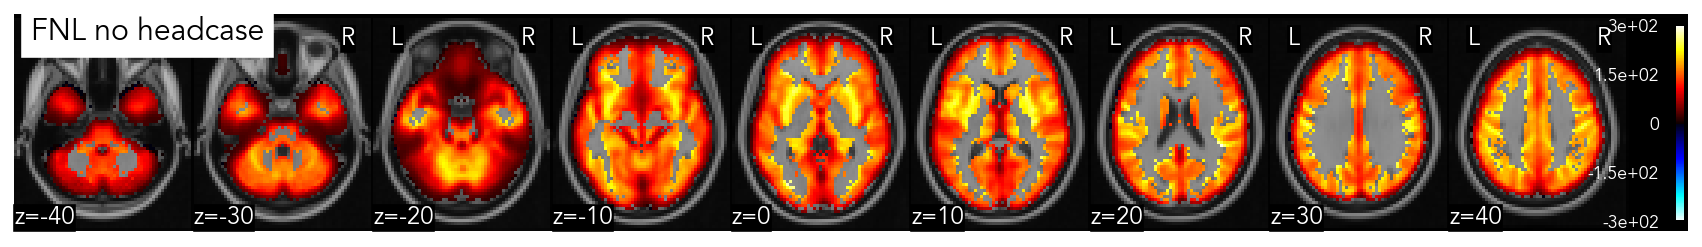

In [124]:
f17_brains.mean().plot(title='FNL no headcase')
plt.savefig(os.path.join(fig_dir, 'tsnr_fnl_nocase.png'))

threshold is ignored for simple axial plots


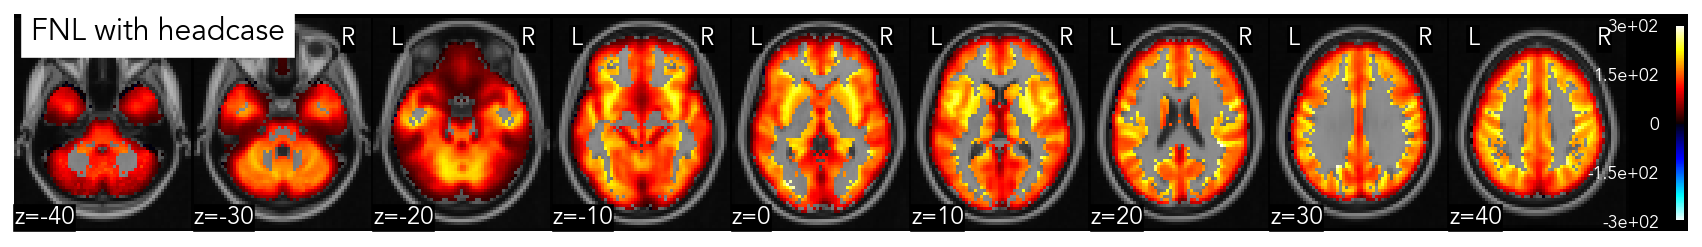

In [125]:
f18_brains.mean().plot(title='FNL with headcase')
plt.savefig(os.path.join(fig_dir, 'tsnr_fnl_withcase.png'))

In [144]:
correlation_permutation(f17_brains.mean().data, f18_brains.mean().data, metric='pearson',n_jobs=1)

{'correlation': 0.9837817547598663, 'p': 0.0001999600079984003}

In [128]:
# Run t-test
X = Design_Matrix(
    np.column_stack([np.ones((63)), np.hstack([np.zeros((37)), np.ones((26))])]),
    columns=["intercept", "group_diff"],
)
all_brains = f17_brains.append(f18_brains)
all_brains.X = X
out = all_brains.regress()

In [131]:
# Nothing survives FDR correction
t = out['t'][1]
p = out['p'][1]
fdr(p.data[~np.isnan(p.data)])

-1

Plotting unthresholded image


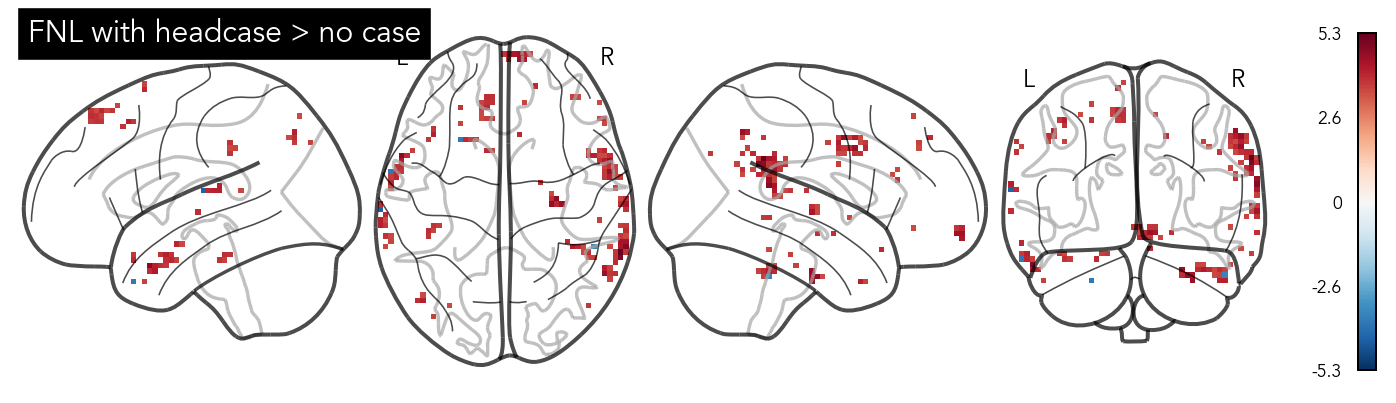

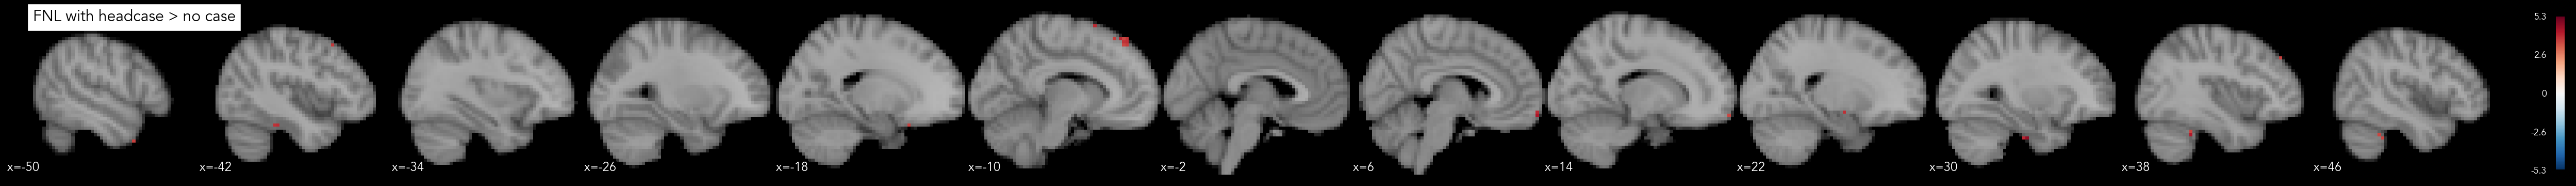

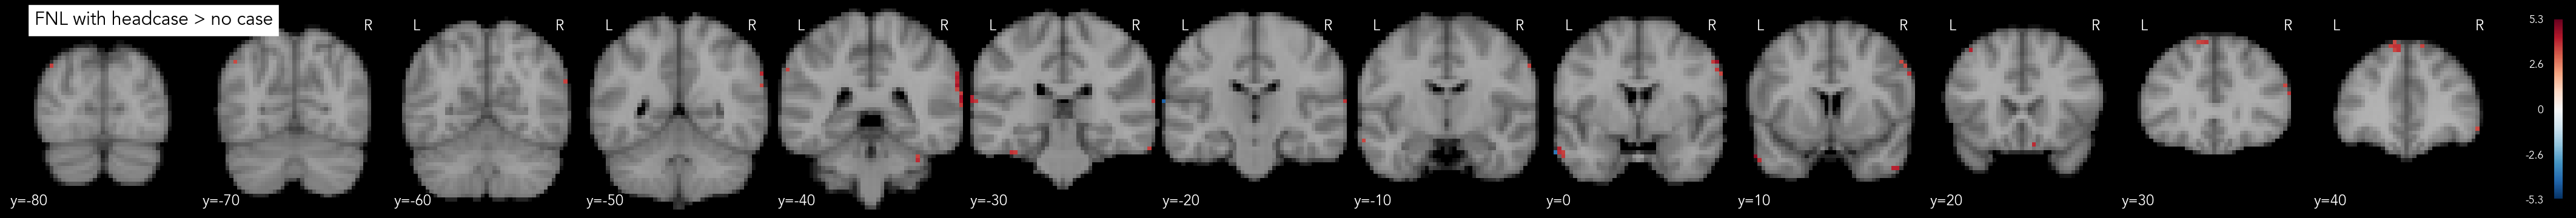

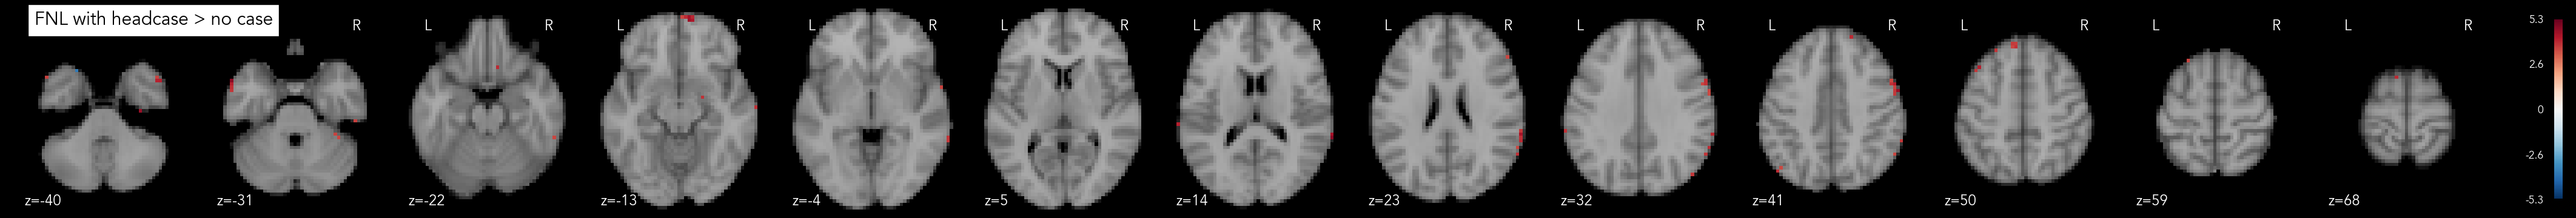

In [136]:
# Plot and save uncorrect p < .001 maps
t = out['t'][1]
p = out['p'][1]
thr_t = threshold(t, p, .001)
thr_t.plot(view='full', title='FNL with headcase > no case', save=os.path.join(fig_dir, 'tsnr_diff_fnlview_unc001.png'))

# Differences over time

In [148]:
from lib.n01 import _mean_diff
from pymer4.stats import cohens_d, boot_func

In [149]:
f17_fd = pd.read_csv(timeseries_dir / "fnl_f17_fd_ts.csv")
f18_fd = pd.read_csv(timeseries_dir / "fnl_f18_fd_ts.csv")
f18_fd = f18_fd.query("condition == 'view'").reset_index(drop=True)

In [157]:
# 30s increments
stats = ['FD','ci_l','ci_u']
results_fd = {k:[] for k in stats}
idx = np.arange(0, 1366, 15)[1:]
for ii, i in enumerate(idx):
    f17_means = f17_fd.groupby("subject_id").apply(lambda g: g.FramewiseDisplacement[:i].mean())
    f18_means = f18_fd.groupby("subject_id").apply(lambda g: g.FramewiseDisplacement[:i].mean())
    diff, ci = boot_func(f18_means.values, f17_means.values, func=_mean_diff, n_jobs=4, n_boot=1000)
    results_fd['FD'].append(diff)
    results_fd['ci_l'].append(ci[0])
    results_fd['ci_u'].append(ci[1])
results_fd['time'] = idx*2 / 60
df_fd = pd.DataFrame(results_fd)

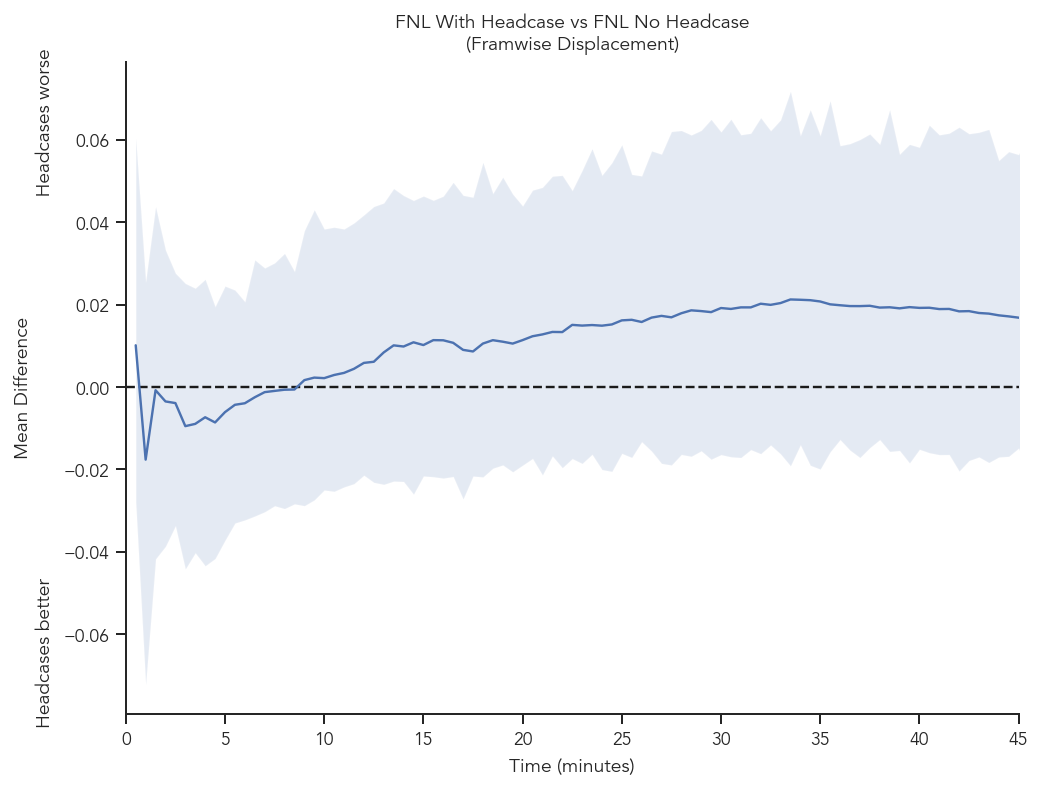

In [153]:
f, ax = plt.subplots(1,1, figsize=(8,6))
_ = ax.plot('time','FD',data=df_fd)
_ = ax.fill_between('time','ci_l','ci_u',data=df_fd,alpha=.15)
_ = ax.set(xlabel='Time (minutes)', xlim=(0,45), title='FNL With Headcase vs FNL No Headcase\n(Framwise Displacement)', ylabel='Mean Difference\nHeadcases better                                                                       Headcases worse')
_ = ax.hlines(0,0,45,color='k',ls='--')
sns.despine()
plt.savefig(fig_dir / "fnl_fddiff_overtime.png",bbox_inches='tight',dpi=300);